In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import seaborn as sb
from numba import jit, njit, int64, float64, boolean
import numba as nb
from numba_i0_i1 import i0, i1
import importlib
import MathieuLib as ML


# from numbalsoda import lsoda_sig, lsoda 

import matplotlib.pyplot as plt
plt.rc("axes", labelsize=22)   # skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=22, top=True, direction="out")
plt.rc("ytick", labelsize=22, right=True, direction="out")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=18)


from joblib import Parallel, delayed
e = 1.602e-19
eps0 = 8.8541878128e-12
u = 1.66e-27
k_B = 1.381e-23 # J/K
Omega = 2*np.pi*305e3

In [5]:
import sys
# sys.path.append('C:\\Users\\au643642\\OneDrive - Aarhus universitet\\Dokumenter\\PhD\\LUNA2 Mass selection tool')
# from mass_selection_functions import popt_all_fit
# xi1, xi0, upper_edge_shrink1, upper_edge_shrink0, lower_edge_shrink1, lower_edge_shrink0 = popt_all_fit[:6]
# from mathieu_functions import upper_mathieu_variable_shrink, lower_mathieu_variable_shrink

def get_z0(r0, mz):
    xi = (xi1*mz + xi0)
    return np.sqrt((xi-r0**2)/2)

def QIT_diagram(RF_V, upper, mz, QIT_r0, QIT_z0):
    xi = (QIT_r0**2 + 2*QIT_z0**2)
    q_to_V = mz*u/e*Omega**2/8 * xi
    if upper:
        return upper_mathieu_variable_shrink(np.atleast_1d(RF_V) / q_to_V, 0, 0, 0, 0)*q_to_V
    return lower_mathieu_variable_shrink(np.atleast_1d(RF_V) / q_to_V, 0, 0, 0, 0)*q_to_V

In [6]:
def DC_to_az(DC,m_to_z,omega,zeta2):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return -16*elementary_charge*DC/(omega**2*zeta2*m_to_z*amu)
def RF_to_qz(RF,m_to_z,omega,zeta2):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return 8*elementary_charge*RF/(omega**2*zeta2*m_to_z*amu)
def az_to_DC(a,m_to_z,omega,zeta2):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return a/(-16*elementary_charge/(omega**2*zeta2*m_to_z*amu))
def qz_to_RF(q,m_to_z,omega,zeta2):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return q/(8*elementary_charge/(omega**2*zeta2*m_to_z*amu))


def DC_to_azp(DC):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return -16*elementary_charge*DC/(Omega**2*zeta2*m_to_z*amu)
def RF_to_qzp(RF):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return 8*elementary_charge*RF/(Omega**2*zeta2*m_to_z*amu)
def az_to_DCp(a):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return a/(-16*elementary_charge/(Omega**2*zeta2*m_to_z*amu))
def qz_to_RFp(q):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return q/(8*elementary_charge/(Omega**2*zeta2*m_to_z*amu))

In [7]:
@njit(nb.types.Tuple((float64[:], float64[:]))(float64, float64, float64))
def find_I0_lns(r0, z0, max_order):
    i = np.arange(max_order+1)
    ln = (2*i+1)*np.pi/2/z0
    res = i0(r0*ln)
    return res, ln
@njit(nb.types.Tuple((float64[:], float64[:]))(float64[:], float64[:], float64[:], float64[:]))
def optimized_besselsum(zs, rs, I0_lns, ln):
    cos_term = np.cos(np.outer(ln, zs))  # Precompute the cos term matrix
    sin_term = np.sin(np.outer(ln, zs))  # Precompute the sin term matrix
    r_ln_matrix = np.outer(ln, rs)
    i0_r_ln_matrix = i0(r_ln_matrix.flatten())
    i1_r_ln_matrix = i1(r_ln_matrix.flatten())
    i0_r_ln_matrix = i0_r_ln_matrix.reshape(r_ln_matrix.shape)
    i1_r_ln_matrix = i1_r_ln_matrix.reshape(r_ln_matrix.shape)
    
    bessel_r_matrix = (-1) ** np.arange(len(ln))[:, np.newaxis]       * i1_r_ln_matrix / I0_lns[:, np.newaxis]
    bessel_z_matrix = (-1) ** (np.arange(len(ln)) + 1)[:, np.newaxis] * i0_r_ln_matrix / I0_lns[:, np.newaxis]
    
    besselsum_r = np.sum(bessel_r_matrix * cos_term, axis=0)
    besselsum_z = np.sum(bessel_z_matrix * sin_term, axis=0)
    
    return besselsum_r, besselsum_z

@njit(float64[:](float64,
     float64[:],
     int64,
     int64,
     int64,
     float64,
     float64,
     float64,
     float64,
     float64[:],
     float64[:],
     int64,
     boolean[:]))
def CIT_EOM_cartesian(t, y, U, V, charge_number, mass, r0, z0, Omega, I0_lns, ln, N_sim, is_not_out_of_bounds):
    q = charge_number*e

    xs = y[:N_sim]
    ys = y[N_sim:2*N_sim]
    rs = np.sqrt(xs**2 + ys**2)

    zs = y[2*N_sim:3*N_sim]
    
    vxs = y[3*N_sim:4*N_sim]
    vys = y[4*N_sim:5*N_sim]
    vzs = y[5*N_sim:]
    

    besselsum_r, besselsum_z = optimized_besselsum(zs, rs, I0_lns, ln)
    t_factor = -2*q/mass/z0 * (U + V*np.cos(Omega*t))

    acc_r = besselsum_r * t_factor
    acc_z = besselsum_z * t_factor

    ret = np.empty_like(y)
    ret[       :  N_sim] = is_not_out_of_bounds * vxs
    ret[  N_sim:2*N_sim] = is_not_out_of_bounds * vys
    ret[2*N_sim:3*N_sim] = is_not_out_of_bounds * vzs

    ret[3*N_sim:4*N_sim] = is_not_out_of_bounds * acc_r * xs / rs
    ret[4*N_sim:5*N_sim] = is_not_out_of_bounds * acc_r * ys / rs
    ret[5*N_sim:       ] = is_not_out_of_bounds * acc_z
    return ret


In [8]:
@njit
def simulate_CIT_no_buffer_gas(U : float, V : float, r0 : float, z0 : float, Omega : float,
                                 mass_amu : int, charge_number : int, N_sim : int, sigma_xyz : float,
                                 T : float, ts):
    mass = mass_amu * u
    mass_gas = 4 * u

    N_order = 10
    I0_lns, ln = find_I0_lns(r0, z0, N_order)
    
    MB_sigma = np.sqrt(k_B*T / mass)
    y0s = np.empty(6*N_sim)
    for i in range(3*N_sim):
        y0s[i]         = np.random.normal(0, sigma_xyz)
        y0s[3*N_sim+i] = np.random.normal(0, MB_sigma)

    y0s[:3*N_sim] = np.clip(y0s[:3*N_sim], -0.8*r0, 0.8*r0)
    y0s[3*N_sim:] = np.clip(y0s[3*N_sim:], -3*MB_sigma, 3*MB_sigma)

    curr_y = y0s
    
    xs = curr_y[:N_sim]
    ys = curr_y[N_sim:2*N_sim]
    zs = curr_y[2*N_sim:3*N_sim]
    vxs = curr_y[3*N_sim:4*N_sim]
    vys = curr_y[4*N_sim:5*N_sim]
    vzs = curr_y[5*N_sim:]

    rs = np.sqrt(xs**2+ys**2)

    axs = np.zeros(N_sim)
    ays = np.zeros(N_sim)
    azs = np.zeros(N_sim)

    out_of_bounds = np.logical_or(np.abs(zs) > z0, np.sqrt(xs**2 + ys**2) > r0)
    not_out_of_bounds = np.logical_not(out_of_bounds)
    curr_N = N_sim
    
    n_steps = len(ts)-1
    N_history = np.zeros(n_steps+1)
    R_history = np.zeros(n_steps+1)
    Z_history = np.zeros(n_steps+1)


    N_history[0] = curr_N
    R_history[0] = np.mean(np.sqrt((xs[not_out_of_bounds])**2+(ys[not_out_of_bounds])**2))
    Z_history[0] = np.mean(np.sqrt(zs[not_out_of_bounds]**2))

    masterR = np.zeros((n_steps+1,N_sim))


    masterZ = np.zeros((n_steps+1,N_sim))
    for ion in range(N_sim):
        masterZ[0,ion] = zs[ion]
        masterR[0,ion] = rs[ion]
    for i in range(n_steps):
        t_start = ts[i]
        t_end = ts[i+1]
        t_step = t_end - t_start

        ## -- Velocity-Verlet
        xs = curr_y[:N_sim]
        ys = curr_y[N_sim:2*N_sim]
        zs = curr_y[2*N_sim:3*N_sim]
        vxs = curr_y[3*N_sim:4*N_sim]
        vys = curr_y[4*N_sim:5*N_sim]
        vzs = curr_y[5*N_sim:]

        # Update positions
        xs += vxs*t_step + 0.5*axs*t_step**2
        ys += vys*t_step + 0.5*ays*t_step**2
        zs += vzs*t_step + 0.5*azs*t_step**2

        # Calculate the acceleration
        dy = CIT_EOM_cartesian(t_start, curr_y, U, V, charge_number, mass, r0, z0, Omega, I0_lns, ln, N_sim, not_out_of_bounds)

        # Update velocities
        curr_y[3*N_sim:4*N_sim] += 0.5 * (axs + dy[3*N_sim:4*N_sim]) * t_step
        curr_y[4*N_sim:5*N_sim] += 0.5 * (ays + dy[4*N_sim:5*N_sim]) * t_step
        curr_y[5*N_sim:]        += 0.5 * (azs + dy[5*N_sim:]       ) * t_step

        # Update accelerations
        axs = dy[3*N_sim:4*N_sim]
        ays = dy[4*N_sim:5*N_sim]
        azs = dy[5*N_sim:]
        ## - END VELOCITY-VERLET

        xs = curr_y[:N_sim]
        ys = curr_y[N_sim:2*N_sim]
        zs = curr_y[2*N_sim:3*N_sim]

        # Check if some of the simulation ions are out of bounds
        out_of_bounds     = np.logical_or(out_of_bounds, np.logical_or(np.abs(zs) > z0, np.sqrt(xs**2 + ys**2) > r0))
        not_out_of_bounds = np.logical_not(out_of_bounds)

        curr_N = np.sum(not_out_of_bounds)
        N_history[i+1] = curr_N

        
        if curr_N == 0:
            print('No Ions Left')
            break
        R_history[i+1] = np.mean(np.sqrt((xs[not_out_of_bounds])**2+(ys[not_out_of_bounds])**2))
        Z_history[i+1] = np.mean(np.sqrt(zs[not_out_of_bounds]**2))
        rs = np.sqrt(xs**2+ys**2)
        for ion in range(N_sim):
            masterZ[i+1,ion] = zs[ion]
            masterR[i+1,ion] = rs[ion]
    return curr_N, curr_y, R_history,Z_history, not_out_of_bounds, N_history, masterR, masterZ

In [5]:
mass = 443
charge_number = 1
N_sim = 100

delta_t = 10e-3
ts = np.arange(0, delta_t, 0.1e-6)
r0 = 10e-3
z0 = 9e-3
sigma_xyz = 2e-3
T = 300

N, curr_y,R_hist, Z_hits,  not_out_of_bounds, N_history,masterR, masterZ\
   = simulate_CIT_no_buffer_gas(U=0, V=420, r0=r0, z0=z0, Omega = Omega,
                                    mass_amu=mass, charge_number=charge_number, 
                                    N_sim=N_sim, sigma_xyz=sigma_xyz, T=T,
                                    ts=ts)

In [6]:
xs = curr_y[:N_sim][not_out_of_bounds]
ys = curr_y[N_sim:2*N_sim][not_out_of_bounds]
rs = np.sqrt(xs**2 + ys**2)
zs = curr_y[2*N_sim:3*N_sim][not_out_of_bounds]
print(N)

37


(0.0, 100.0)

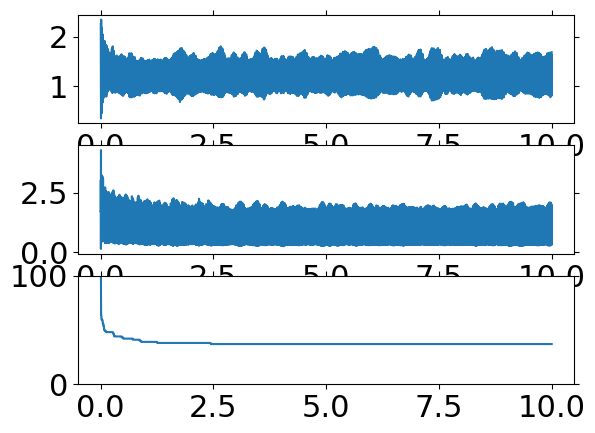

In [7]:
fig,ax = plt.subplots(3,1)
ax[0].plot(ts*1e3,R_hist*1e3)
ax[1].plot(ts*1e3,Z_hits*1e3)
ax[2].plot(ts*1e3,N_history)
ax[2].set_ylim(0,100)

(0.0, 110.00000000000001)

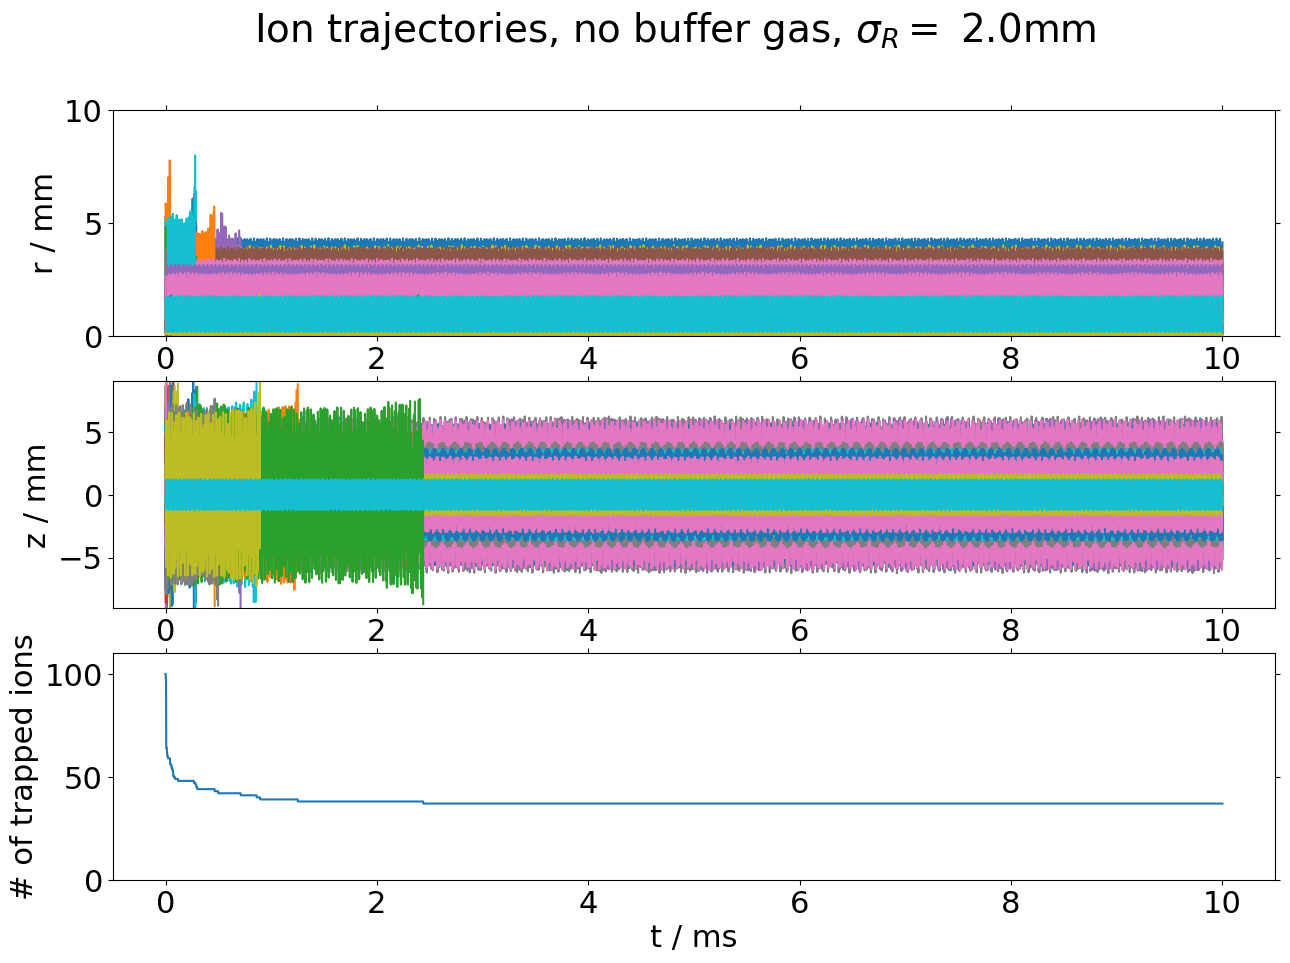

In [8]:
fig,ax = plt.subplots(3,1,figsize = (15,10))
# ax[0].plot(ts,np.array(masterR)*1e3)
# ax[1].plot(ts,np.array(masterZ)*1e3)

for column_nr in range(masterR.shape[1]):
    Rs = masterR[:,column_nr]
    Zs = masterZ[:,column_nr]
    breakpointZ = len(ts)-1
    breakpointR = len(ts)-1
    for j,z in enumerate(Zs):
        if (np.abs(z)>= z0) or (np.isnan(z)):
            breakpointZ = j
            break
    for j,r in enumerate(Rs):
        if (r>= r0) or (np.isnan(r)):
            breakpointR = j
            break
    breakpoint = np.min([breakpointR,breakpointZ])            
    ax[0].plot(ts[:breakpoint]*1e3,Rs[:breakpoint]*1e3)
    ax[1].plot(ts[:breakpoint]*1e3,Zs[:breakpoint]*1e3)



ax[0].set_ylim(0,(r0)*1e3)
ax[1].set_ylim(-z0*1e3,z0*1e3)
ax[2].set_xlabel('t / ms')
ax[0].set_ylabel('r / mm')
ax[1].set_ylabel('z / mm')
ax[2].set_ylabel('# of trapped ions')
ax[2].plot(ts*1e3,N_history)
fig.suptitle(r'Ion trajectories, no buffer gas, $\sigma_R =$ {0}mm'.format(sigma_xyz*1e3),fontsize = 28)
ax[2].set_ylim(0,N_sim*1.1)

(0.0, 1.0)

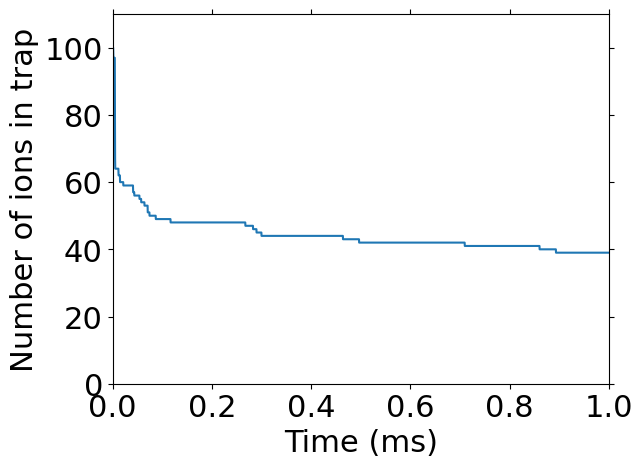

In [9]:
plt.plot(ts*1e3, N_history)
plt.xlabel('Time (ms)')
plt.ylabel('Number of ions in trap')
plt.ylim(0, 110)
plt.xlim(0, 1)

In [10]:
VDCs = np.linspace(-50,120,50)
VRFs = np.linspace(250,500,50)
# DataGrid = np.zeros((len(VDCs),len(UDCs)))
# for i,VDC in enumerate(VDCs):
#     for j,VRF in enumerate(VRFs):
#         N, curr_y, not_out_of_bounds, N_history\
#         = simulate_CIT_no_buffer_gas(U=VDC, V=VRF, r0=r0, z0=z0, Omega = Omega,
#                                     mass_amu=mass, charge_number=charge_number, 
#                                     N_sim=N_sim, sigma_xyz=sigma_xyz, T=T,
#                                     ts=ts)
#         DataGrid[i,j] = N

In [78]:
q_array = RF_to_qz(VRFs, 443, Omega, 2.36*1e-4)
a_array = DC_to_az(VDCs, 443, Omega, 2.36*1e-4)

[topA,topQ,bottomA,bottomQ] = ML.makeStabilityDiagram(a_array,q_array,0)

In [95]:
xi = np.sqrt(2.35e-4)
V = 365.51724137931035
RF_edge_centers_top = qz_to_RF(bottomQ, 443, Omega, 2.36*1e-4)
DC_edge_centers_top = az_to_DC(bottomA, 443, Omega, 2.36*1e-4)


print (DC_edge_centers_top)
print(DC_edge_centers_top[RF_edge_centers_top == RF_edge_centers_top[37]][0])
delta_U_V = 15

DC_arr = np.arange(DC_edge_centers_top[RF_edge_centers_top == RF_edge_centers_top[37]]-delta_U_V,DC_edge_centers_top[RF_edge_centers_top == RF_edge_centers_top[37]]+delta_U_V,1)
print(DC_arr)
def get_stability(RF):
    mass = 443
    charge_number = 1
    N_sim = 100


    DC_arr = np.arange(DC_edge_centers_top[RF_edge_centers_top == RF]-delta_U_V,DC_edge_centers_top[RF_edge_centers_top == RF]+delta_U_V,1)
    delta_t = 10e-3
    ts = np.arange(0, delta_t, 0.1e-6)
    r0 = 10e-3
    z0 = 9e-3
    sigma_xyz = 2e-3
    T = 300
    N_arr = []
    for DC in np.arange(-40,40,0.5):
        N, curr_y,R_hist, Z_hits,  not_out_of_bounds, N_history,masterR, masterZ\
            = simulate_CIT_no_buffer_gas(U=DC, V=RF, r0=r0, z0=z0, Omega = Omega,
                                            mass_amu=mass, charge_number=charge_number, 
                                            N_sim=N_sim, sigma_xyz=sigma_xyz, T=T,
                                            ts=ts)
        N_arr.append(N)
    return N_arr
U_edge_long_sim = Parallel(n_jobs=14, verbose=12)(delayed(get_stability)(RF) for RF in RF_edge_centers_top)

[-15.30612245 -15.30612245 -15.30612245 -15.30612245 -15.30612245
 -18.7755102  -18.7755102  -18.7755102  -18.7755102  -18.7755102
 -22.24489796 -22.24489796 -22.24489796 -22.24489796 -22.24489796
 -25.71428571 -25.71428571 -25.71428571 -25.71428571 -29.18367347
 -29.18367347 -29.18367347 -29.18367347 -32.65306122 -32.65306122
 -32.65306122 -36.12244898 -36.12244898 -32.65306122 -29.18367347
 -25.71428571 -25.71428571 -22.24489796 -18.7755102  -15.30612245
 -11.83673469  -8.36734694  -4.89795918  -1.42857143  -1.42857143
   2.04081633   5.51020408   8.97959184  12.44897959  15.91836735
  19.3877551   22.85714286  22.85714286  26.32653061  29.79591837]
-4.897959183673471
[-19.89795918 -18.89795918 -17.89795918 -16.89795918 -15.89795918
 -14.89795918 -13.89795918 -12.89795918 -11.89795918 -10.89795918
  -9.89795918  -8.89795918  -7.89795918  -6.89795918  -5.89795918
  -4.89795918  -3.89795918  -2.89795918  -1.89795918  -0.89795918
   0.10204082   1.10204082   2.10204082   3.10204082   4.

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   1 tasks      | elapsed: 49.6min
[Parallel(n_jobs=14)]: Done   2 tasks      | elapsed: 51.0min
[Parallel(n_jobs=14)]: Done   3 tasks      | elapsed: 51.8min
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed: 51.9min
[Parallel(n_jobs=14)]: Done   5 tasks      | elapsed: 53.0min
[Parallel(n_jobs=14)]: Done   6 tasks      | elapsed: 53.0min
[Parallel(n_jobs=14)]: Done   7 tasks      | elapsed: 53.7min
[Parallel(n_jobs=14)]: Done   8 tasks      | elapsed: 55.1min
[Parallel(n_jobs=14)]: Done   9 tasks      | elapsed: 57.2min
[Parallel(n_jobs=14)]: Done  10 tasks      | elapsed: 57.3min
[Parallel(n_jobs=14)]: Done  11 tasks      | elapsed: 58.2min
[Parallel(n_jobs=14)]: Done  12 tasks      | elapsed: 59.4min
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed: 60.1min
[Parallel(n_jobs=14)]: Done  14 tasks      | elapsed: 61.2min
[Parallel(n_jobs=14)]: Done  15 tasks      | elapsed: 1

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 1, 3, 2, 4, 3, 2, 8, 6, 5, 11, 9, 30, 24, 54, 52, 66, 67, 76, 72, 77, 70, 67, 67, 71, 68, 69, 68, 74, 77, 85, 83, 84, 83, 87, 87, 84, 94, 94, 94, 92, 91, 85, 91, 94, 92, 92, 89, 93, 91, 94, 93, 98, 97, 94, 89, 90, 94, 95, 92, 91, 92, 90, 94, 96, 99, 92, 96, 92, 97, 94, 96, 91, 95, 96, 96, 98, 98, 98, 99, 94, 98, 96, 96, 96, 99, 99, 95, 95, 94, 93, 94, 96, 89, 90, 95, 92, 87, 87, 86, 85, 87, 82, 53, 56, 13, 16, 5, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 5, 2, 3, 3, 5, 3, 5, 7, 29, 24, 52, 45, 67, 64, 74, 74, 86, 77, 90, 88, 81, 88, 91, 84, 86, 84, 87, 91, 87, 82, 71, 64, 63, 66, 75, 76, 82, 84, 84, 85, 82, 87, 86, 89, 93, 93, 93, 90, 89, 90, 92, 89, 89, 93, 92, 92, 90, 92, 92, 89, 93, 97, 95, 93, 91, 92, 94, 95, 94, 96, 94, 97, 92, 96, 95, 95, 9

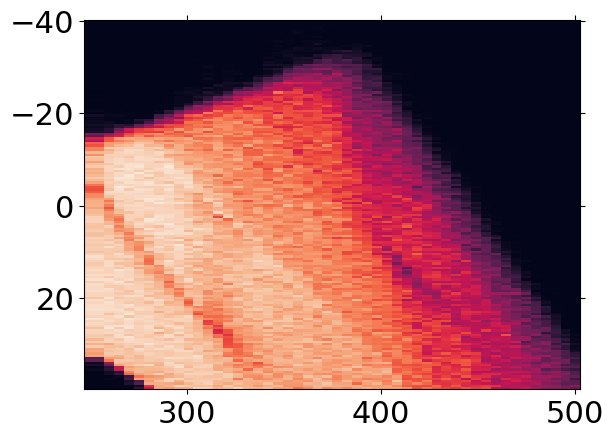

In [99]:
print(U_edge_long_sim)
DATA = np.array(U_edge_long_sim[1])
for line in U_edge_long_sim[1:]:
    DATA = np.vstack((DATA,np.array(line)))
    # print()
print(DATA.T.shape)
np.savetxt('DataEdge.txt',DATA)
np.savetxt('EdgeRF.txt',VRFs)
np.savetxt('EdgeDC.txt',np.arange(-40,40,0.5))
fig,ax = plt.subplots()



print(U_edge_long_sim[0])

RF_arr = RF_edge_centers_top
DC_arr = np.arange(DC_edge_centers_top[RF_edge_centers_top == RF_edge_centers_top[0]]-delta_U_V,DC_edge_centers_top[RF_edge_centers_top == RF_edge_centers_top[0]]+delta_U_V,1)
N_arr = np.array(U_edge_long_sim[0])

# for j,RF in enumerate(RF_arr):
#     DC_arr = np.arange(DC_edge_centers_top[RF_edge_centers_top == RF]-delta_U_V,DC_edge_centers_top[RF_edge_centers_top == RF]+delta_U_V,1)
#     N_arr = U_edge_long_sim[j]
#     for DC,N in zip(DC_arr,N_arr):
#         sc = ax.scatter(RF,DC,c = N,vmin = 0, vmax = 100,cmap = 'rocket')


ax.pcolormesh(VRFs,np.arange(-40,40,0.5),DATA.T,cmap = 'rocket')


fig.colorbar(sc)
ax.invert_yaxis()
# print(np.arange(DC_edge_centers_top[RF_edge_centers_top == RF_edge_centers_top[0]]-delta_U_V,DC_edge_centers_top[RF_edge_centers_top == RF_edge_centers_top[0]]+delta_U_V,1))
# ax.pcolormesh([np.array([RF_edge_centers_top[0]]),np.arange(DC_edge_centers_top[RF_edge_centers_top == RF_edge_centers_top[0]]-delta_U_V,DC_edge_centers_top[RF_edge_centers_top == RF_edge_centers_top[0]]+delta_U_V,1)],U_edge_long_sim[0])



# for j,Ns in enumerate(U_edge_long_sim):
#     RFVal = RF_edge_centers_top[j]
#     ax.contourf([RFVal, np.arange(DC_edge_centers_top[RF_edge_centers_top == RFVal]-delta_U_V,DC_edge_centers_top[RF_edge_centers_top == RFVal]+delta_U_V,1)], Ns)

(50,) (50,)


TypeError: Dimensions of C (100, 100) should be one smaller than X(50) and Y(50) while using shading='flat' see help(pcolormesh)

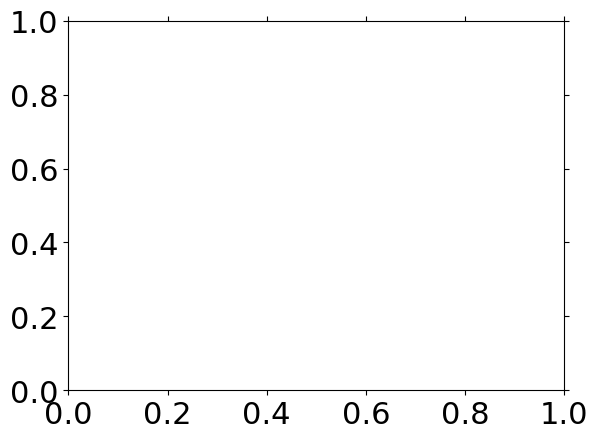

In [90]:
fig,ax = plt.subplots()
print(VDCs.shape,VRFs.shape)
DATA = np.loadtxt(r'C:\Users\lenle\Documents\PhD-Work\Lab Stuff\ESI\Thomas Simulations\DATA_No_buffer_fine_100_x_100.txt')

heatmap = ax.pcolormesh(VRFs,VDCs,DATA.T, cmap = 'rocket')
fig.colorbar(heatmap)
ax.invert_yaxis()
# ax.scatter(420,0)

In [208]:
np.savetxt("DATA_No_buffer_fine_100_x_100_2mm10ms.txt",DATA)
np.savetxt("VRF_No_buffer_fine_100_x_100_2mm10ms.txt",VRFs)
np.savetxt("VDC_No_buffer_fine_100_x_100_2mm10ms.txt",VDCs)


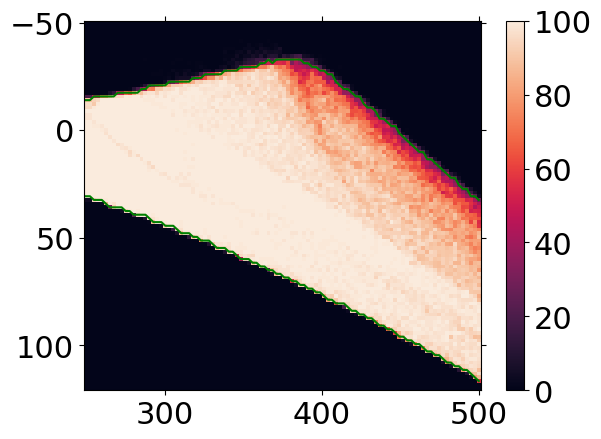

In [209]:
def EdgeDetector(DATASET,XArray,YArray,discriminatorValue):
    edgeY = []
    edgeX = []
    for j,x in enumerate(XArray):
        for k,y in enumerate(YArray):
            if DATASET[k,j] > discriminatorValue:
                edgeY.append(y)
                edgeX.append(x)
                break
    return np.array(edgeX) , np.array(edgeY)

edgeX1,edgeY1 = EdgeDetector(DATA.T,VRFs,VDCs,20)
ax.plot(edgeX1,edgeY1,'g')
edgeX2, edgeY2 = EdgeDetector(np.flip(DATA,axis = 1).T,VRFs,np.flip(VDCs),20)
ax.plot(edgeX2,edgeY2,'g')
fig


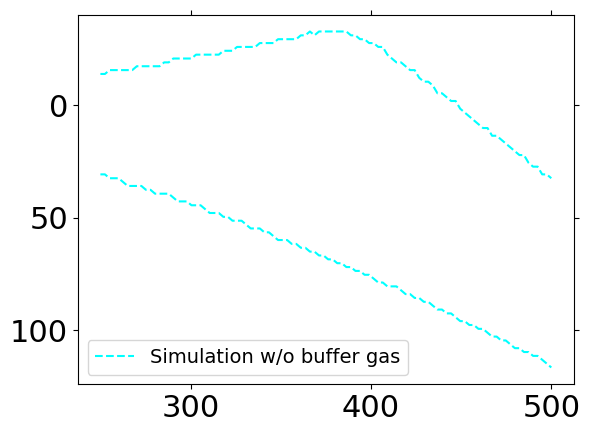

In [216]:
fig_Overall,ax_Overall = plt.subplots()
ax_Overall.plot(edgeX1,edgeY1,'#00FFFF',ls = '--',label = 'Simulation w/o buffer gas')
ax_Overall.plot(edgeX2,edgeY2,'#00FFFF',ls = '--')

ax_Overall.legend(fontsize = 14)
ax_Overall.invert_yaxis()

(100,) (100,)


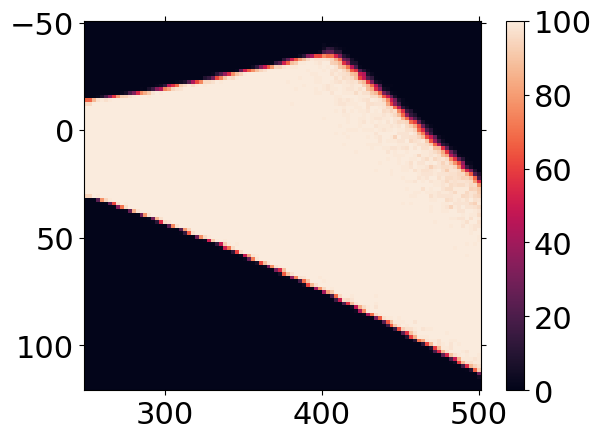

In [ ]:
#Now we import the simulation with buffergas!

fig,ax = plt.subplots()
print(VDCs.shape,VRFs.shape)
DATA = np.loadtxt(r'C:\Users\au581149\PhD-Work\Lab Stuff\ESI\Thomas Simulations\DATA_w_buffer_fine_100_x_100.txt')

heatmap = ax.pcolormesh(VRFs,VDCs,DATA.T, cmap = 'rocket')
fig.colorbar(heatmap)
ax.invert_yaxis()
# ax.scatter(420,0)

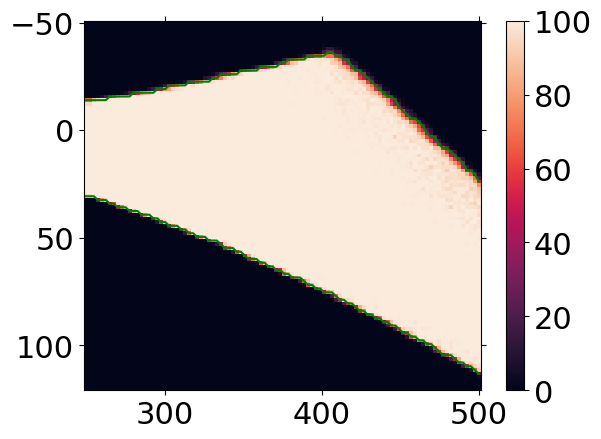

In [ ]:
edgeX1B,edgeY1B = EdgeDetector(DATA.T,VRFs,VDCs,20)
ax.plot(edgeX1B,edgeY1B,'g')
edgeX2B, edgeY2B = EdgeDetector(np.flip(DATA,axis = 1).T,VRFs,np.flip(VDCs),20)
ax.plot(edgeX2B,edgeY2B,'g')
fig

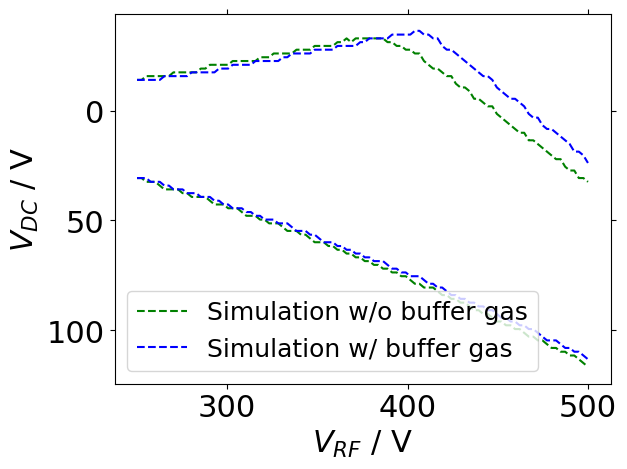

In [ ]:
ax_Overall.plot(edgeX1B,edgeY1B,'#FF00FF',ls = '--',label = 'Simulation w/ buffer gas')
ax_Overall.plot(edgeX2B,edgeY2B,'#FF00FF',ls = '--')



ax_Overall.set_xlabel(r'$V_{RF}$ / V')
ax_Overall.set_ylabel(r'$V_{DC}$ / V')
ax_Overall.legend()
fig_Overall



In [ ]:
zeta2 =2.36*1e-4
m_to_z = 443
omega = 2*np.pi*1e3*300

In [ ]:
a_array = DC_to_az(np.linspace(np.min(VDCs),np.max(VDCs),500),443,300*2*np.pi*1e3,2.36*1e-4)
q_array = RF_to_qz(np.linspace(np.min(VRFs),np.max(VRFs),500),443,300*2*np.pi*1e3,2.36*1e-4)

kappa = 0.2
[topA0,topQ0,bottomA0,bottomQ0] = ML.makeStabilityDiagram(a_array,q_array,0)
[topA025,topQ025,bottomA025,bottomQ025] = ML.makeStabilityDiagram(a_array,q_array,kappa)


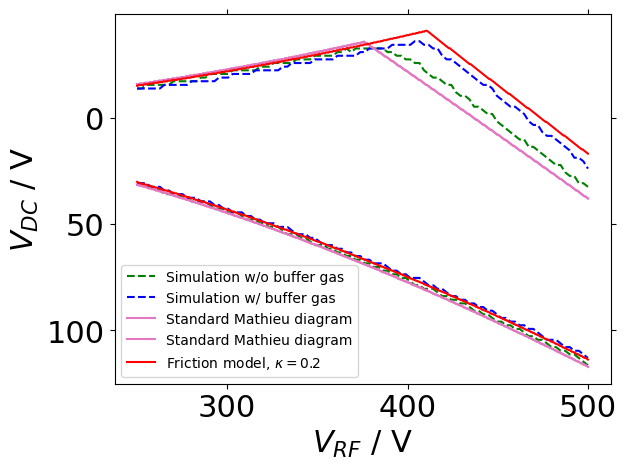

In [ ]:
ax_Overall.plot(qz_to_RF(topQ0,m_to_z,omega,zeta2),az_to_DC(topA0,m_to_z,omega,zeta2),'#00FF00',label = 'Standard Mathieu diagram')
ax_Overall.plot(qz_to_RF(bottomQ0,m_to_z,omega,zeta2),az_to_DC(bottomA0,m_to_z,omega,zeta2),'#00FF00')


ax_Overall.plot(qz_to_RF(topQ025,m_to_z,omega,zeta2),az_to_DC(topA025,m_to_z,omega,zeta2),'#0000FF',label = r'Friction model, $\kappa = {0}$'.format(kappa))
ax_Overall.plot(qz_to_RF(bottomQ025,m_to_z,omega,zeta2),az_to_DC(bottomA025,m_to_z,omega,zeta2),'#0000FF')
ax_Overall.legend(fontsize = 10,loc = 'lower left')
fig_Overall

(70, 25)


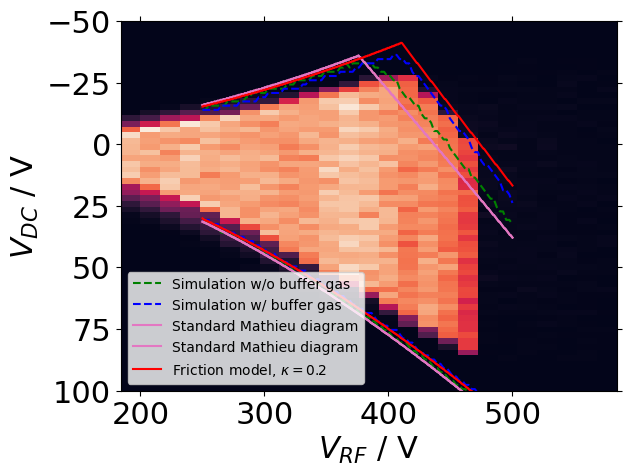

In [ ]:
DATA = np.loadtxt(r'C:\Users\au581149\PhD-Work\Lab Stuff\ESI\Mass Selection\MathieuMapCOARSE4P_09_12_2024.txt',skiprows = 2, delimiter = ',')

UDCs = DATA[:,3]
VRFs = DATA[:,4]
Counts = DATA[:,1]





UniqueRFs = np.unique(VRFs)
UniqueDCs = np.unique(UDCs)
DATAGrid = np.zeros((len(UniqueDCs),len(UniqueRFs)))
DATAGridNorm = np.zeros((len(UniqueDCs),len(UniqueRFs)))
print(np.shape(DATAGrid))
for j,VRF in enumerate(UniqueRFs):
    for m,DC in enumerate(UniqueDCs):
        signal = np.sum(Counts[np.bitwise_and(UDCs == DC,VRFs == VRF)])
        DATAGrid[m,j] = signal
        DATAGridNorm[m,j] = signal
    DATAGridNorm[:,j] /= np.max(DATAGridNorm[:,j])

colormesh1 = ax_Overall.pcolormesh(UniqueRFs*0.96,UniqueDCs-23,DATAGrid,cmap = 'rocket')
ax_Overall.set_ylim(-50,100)
ax_Overall.invert_yaxis()
fig_Overall